In [25]:
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import sqlite3
import seaborn as sns

In [45]:
sns.set(rc={'figure.figsize':(10,8)})

In [46]:
con = sqlite3.connect('bgg.db')
cur = con.cursor()

In [47]:
query = '''
 SELECT t1.id, title, CAST(avg_rating AS FLOAT64), 
        CAST(std as FLOAT64) std, CAST(play_time AS INT64) play_time
 
 FROM TOP_GAMES_FULL t1
'''

results = cur.execute(query)
result_li = [elem for elem in results.fetchall()]

In [48]:
df = pd.DataFrame(data=result_li, columns = ['id','title','score', 'std','play_time'])

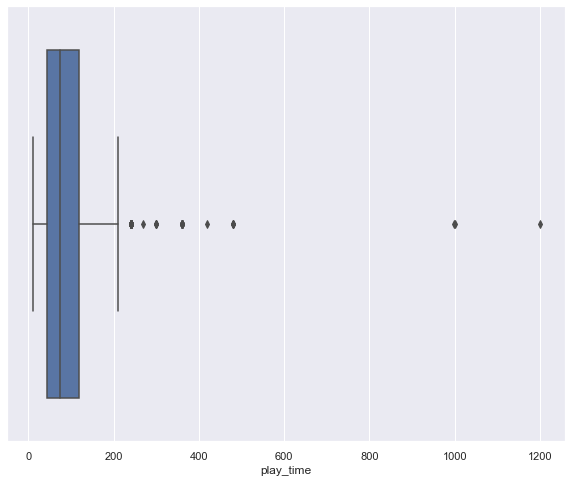

In [49]:
sns.boxplot(df['play_time'])

In [50]:
df.sort_values('play_time', ascending=False).head(15)

,id,title,score,std,play_time
317,255984,sleeping_gods,8.61552,1.39918,1200
38,180263,7th_continent,8.09348,1.63416,1000
997,234669,legacy_dragonholt,7.27396,1.71204,999
5,233078,twilight_imperium_fourth_edition,8.68469,1.59933,480
333,243,advanced_squad_leader,7.99375,2.06461,480
168,91,paths_glory,8.05662,1.64940,480
604,29603,d_day_omaha_beach,8.27387,1.39239,480
709,41066,virgin_queen,8.04787,1.64665,420
536,130960,triumph_tragedy_european_balance_power_1936_1945,8.16149,1.44092,360
204,421,1830_railways_robber_barons,7.87979,1.61974,360


According to the boxplot, everything about ~200 is an outlier. However, I'll only remove the ones greater than 480 (8 hours) since I think the 3-4 hours games might be interesting)

In [51]:
df = df[df['play_time'] <= 480]

30 min to 2 hours is the most common, as expected

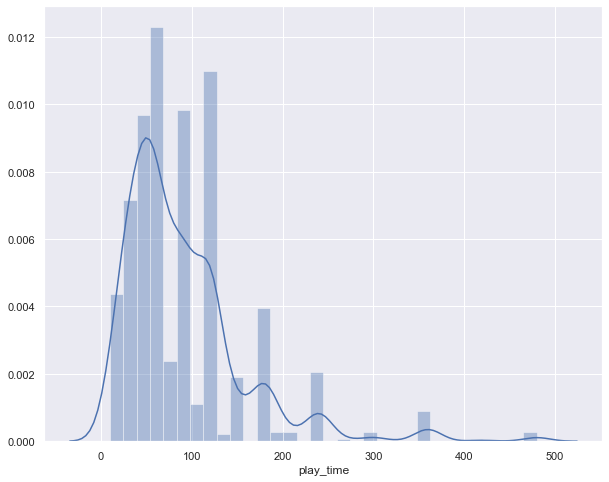

In [52]:
sns.distplot(df.play_time)

Is there a relationship between playtime and game score?

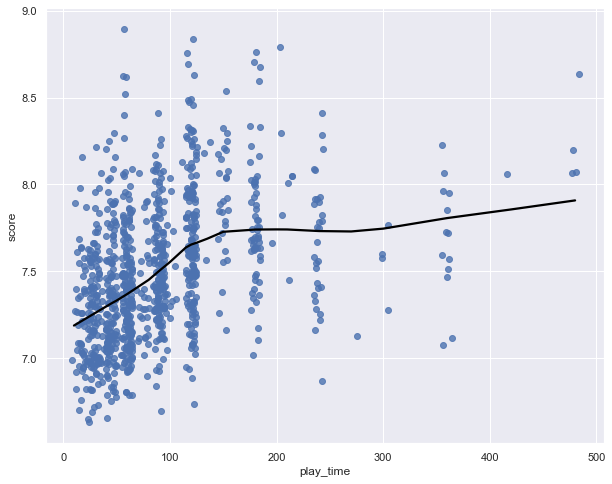

In [181]:
sns.regplot(data=df, x='play_time', y='score', lowess=True,line_kws={"color": "black"}, y_jitter=0.1, x_jitter=5)

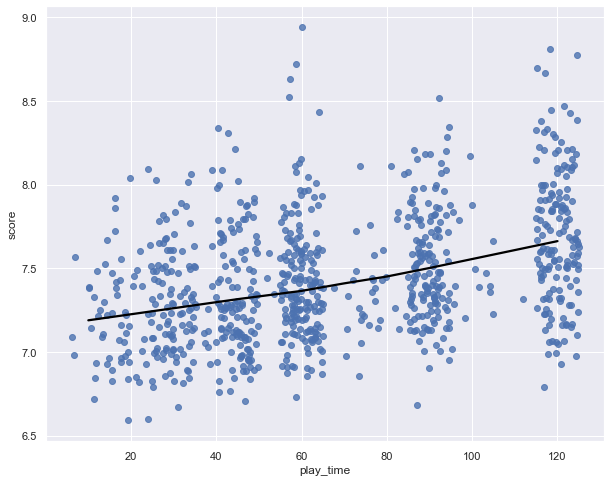

In [182]:
sns.regplot(data=df[df['play_time'] <= 120],
            x='play_time', y='score', lowess=True,line_kws={"color": "black"}, y_jitter=0.1, x_jitter=5)

Seems like longer games score better. Are longer games also more divisive?

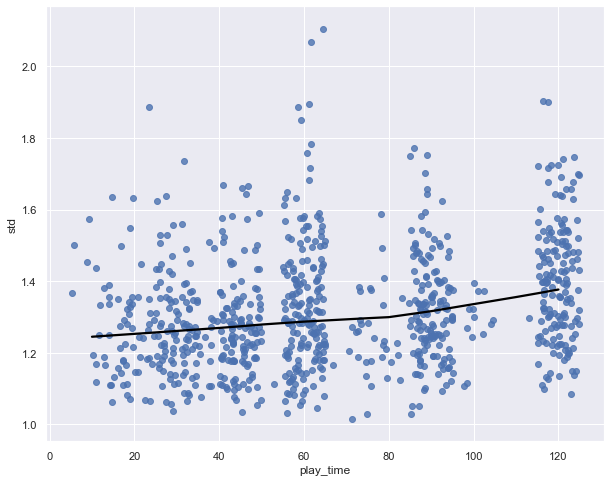

In [183]:
sns.regplot(data=df[df['play_time'] <= 120],
            x='play_time', y='std', lowess=True,line_kws={"color": "black"}, y_jitter=0.1, x_jitter=5)

Seems like they are more divisive as well.

Next step: Let's see if this relationship is statistically significant with a series of regression models

In [70]:
import statsmodels.formula.api as smf

In [75]:
results=smf.ols(data=df, formula ='score ~ play_time').fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     184.8
Date:                Fri, 03 Sep 2021   Prob (F-statistic):           1.00e-38
Time:                        17:01:43   Log-Likelihood:                -394.43
No. Observations:                 997   AIC:                             792.9
Df Residuals:                     995   BIC:                             802.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2879      0.019    382.785      0.000       7.251       7.325
play_time      0.0023      0.000     13.593      0.000       0.002       0.003
==============================================================================
Omnibus:                       59.312   Durbin-Watson:                   1.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.125
Skew:                           0.588   Prob(JB):                     5.92e-16
Kurtosis:                       3.550   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The relationship is significant at any conventional level. A 1 minute increase in playtime is assosciated with a 0.0023 increase in score. More readably, a one hour increase in play time is assocaited with a 0.0023 * 60 or .138 increase in score

Next, let's check for a quadradic. Are there diminishing returns to playtime?

In [86]:
results=smf.ols(data=df, formula ='score ~ play_time + play_time^2').fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     92.56
Date:                Fri, 03 Sep 2021   Prob (F-statistic):           1.37e-37
Time:                        17:10:51   Log-Likelihood:                -394.20
No. Observations:                 997   AIC:                             794.4
Df Residuals:                     994   BIC:                             809.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.2873      0.019    382.297      0.000       7.250       7.325
play_time        -0.0018      0.006     -0.298      0.766      -0.014       0.010
play_time ^ 2     0.0041      0.006      0.669      0.504      -0.008       0.016
==============================================================================
Omnibus:                       57.878   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.010
Skew:                           0.582   Prob(JB):                     1.71e-15
Kurtosis:                       3.531   Cond. No.                         268.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No diminishing retursn to playtime it seems, as neither play time variable is stastistically different from 0 at anything close to a conventional level

Now, let's get an elastcitity!

In [84]:
results=smf.ols(data=df, formula ='np.log(score) ~ np.log(play_time)').fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(score)   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     239.6
Date:                Fri, 03 Sep 2021   Prob (F-statistic):           1.40e-48
Time:                        17:07:06   Log-Likelihood:                 1648.6
No. Observations:                 997   AIC:                            -3293.
Df Residuals:                     995   BIC:                            -3283.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.8745      0.009    206.776      0.000       1.857       1.892
np.log(play_time)     0.0324      0.002     15.478      0.000       0.028       0.037
==============================================================================
Omnibus:                       35.517   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.387
Skew:                           0.470   Prob(JB):                     4.62e-09
Kurtosis:                       3.203   Cond. No.                         28.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A 1% increase in playtime is assosciated with a 0.0324 percent increase in score. Highly inelastic!

# Adding Category

In [131]:
results = cur.execute('SELECT * FROM BGG_CATEGORIES')
result_li = [r for r  in results.fetchall()]
cat_df = pd.DataFrame(data=result_li, columns = ['id', 'category'])

Most popular categories

In [133]:
pivot = pd.pivot_table(data=cat_df,index='category',values='id',aggfunc='count').sort_values('id',ascending=False)
pivot.reset_index(inplace=True)
pivot.head(10)

,category,id
0,Card Game,246
1,Fantasy,210
2,Economic,200
3,Fighting,156
4,Science Fiction,130
5,Adventure,109
6,Wargame,102
7,Miniatures,97
8,Exploration,94
9,Medieval,94


In [134]:
pivot = pivot[pivot.index <=9]

Let's make a dataframe that tells us whether or not a game has a certain category

In [135]:
new_df = pd.DataFrame(data=cat_df.id.unique(), columns=['id'])

In [136]:
for col in pivot.category:
    new_df[col] = 0

new_df.head()

,id,Card Game,Fantasy,Economic,Fighting,Science Fiction,Adventure,Wargame,Miniatures,Exploration,Medieval
0,174430,0,0,0,0,0,0,0,0,0,0
1,161936,0,0,0,0,0,0,0,0,0,0
2,224517,0,0,0,0,0,0,0,0,0,0
3,167791,0,0,0,0,0,0,0,0,0,0
4,291457,0,0,0,0,0,0,0,0,0,0


In [149]:
# Create 1/0 columns for whether or not a game belongs in certain categories
# Note that some games will have multiple categories, some will have none
for idx in cat_df.id.unique():
    for cat in cat_df.loc[cat_df['id'] == idx, 'category']:
        if cat in pivot.category.values:
            new_df.loc[new_df['id'] == idx, cat] = 1

In [150]:
new_df.head(10)

,id,Card Game,Fantasy,Economic,Fighting,Science Fiction,Adventure,Wargame,Miniatures,Exploration,Medieval
0,174430,0,1,0,1,0,1,0,1,1,0
1,161936,0,0,0,0,0,0,0,0,0,0
2,224517,0,0,1,0,0,0,0,0,0,0
3,167791,0,0,1,0,1,0,0,0,0,0
4,291457,0,1,0,1,0,1,0,1,1,0
5,233078,0,0,1,0,1,0,1,0,1,0
6,220308,0,0,1,0,1,0,0,0,0,0
7,187645,0,0,0,1,1,0,1,1,0,0
8,182028,1,0,1,0,0,0,0,0,0,0
9,193738,0,0,1,0,0,0,0,0,0,0


In [154]:
merge_df = df.merge(new_df, on='id',how='inner')

In [156]:
# Renaming just to avoid spaces in headers
merge_df.rename(columns={'Card Game':'Card_Game', 'Science Fiction': 'ScienceFiction'}, inplace=True)

In [160]:
# Create string for formula with all the category columns
formula_str = ''
for idx, col in enumerate(merge_df.iloc[:, 4:].columns):
    formula_str += col + ' '
    # Add plus sign if it's not the last column
    if idx != len(merge_df.iloc[:, 4:].columns) - 1:
        formula_str += '+ '

formula_str

'play_time + Card_Game + Fantasy + Economic + Fighting + ScienceFiction + Adventure + Wargame + Miniatures + Exploration + Medieval '

In [166]:
# Also, just for readability, let's put play_time in terms of hours
merge_df['play_time'] = merge_df['play_time'] / 60

In [167]:
model = smf.ols(data=merge_df,formula='score~' + formula_str).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     24.08
Date:                Sat, 04 Sep 2021   Prob (F-statistic):           3.01e-44
Time:                        08:20:54   Log-Likelihood:                -359.18
No. Observations:                 993   AIC:                             742.4
Df Residuals:                     981   BIC:                             801.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.2396      0.024    301.396      0.000       7.192       7.287
play_time          0.1137      0.012      9.451      0.000       0.090       0.137
Card_Game         -0.0076      0.028     -0.269      0.788      -0.063       0.048
Fantasy            0.1045      0.032      3.258      0.001       0.042       0.167
Economic           0.1414      0.030      4.698      0.000       0.082       0.200
Fighting          -0.0503      0.037     -1.361      0.174      -0.123       0.022
ScienceFiction     0.1187      0.035      3.437      0.001       0.051       0.187
Adventure          0.0121      0.044      0.276      0.783      -0.074       0.098
Wargame            0.0761      0.043      1.753      0.080      -0.009       0.161
Miniatures         0.1988      0.045      4.407      0.000       0.110       0.287
Exploration       -0.0065      0.043     -0.152      0.879      -0.090       0.077
Medieval           0.0068      0.038      0.178      0.859      -0.068       0.082
==============================================================================
Omnibus:                       44.056   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.100
Skew:                           0.514   Prob(JB):                     2.18e-11
Kurtosis:                       3.363   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Above we found a 0.138 increase in score from an additional hour of playtime. Here it's declined a bit to 0.114, but that's not a practically large difference. In short, it doesn't seem like the effect size was dependent on category, or at least not on these 10

Are longer games rated more? Maybe there's a selection bias: longer games only get played by those who know they will like it. Shorter games might get a wider audience of people more ambivalent to the game

In [214]:
query = '''
 SELECT t1.id, title, CAST(avg_rating AS FLOAT64) avg_rating, 
        CAST(ratings as INT64) ratings, CAST(play_time AS INT64) play_time
 
 FROM TOP_GAMES_FULL t1
 
 WHERE 1=1
     AND CAST(play_time AS INT64) <= 480
'''

results = cur.execute(query)
result_li = [elem for elem in results.fetchall()]

In [215]:
rating_df = pd.DataFrame(data=result_li, columns = ['id', 'title','score','ratings','play_time'])

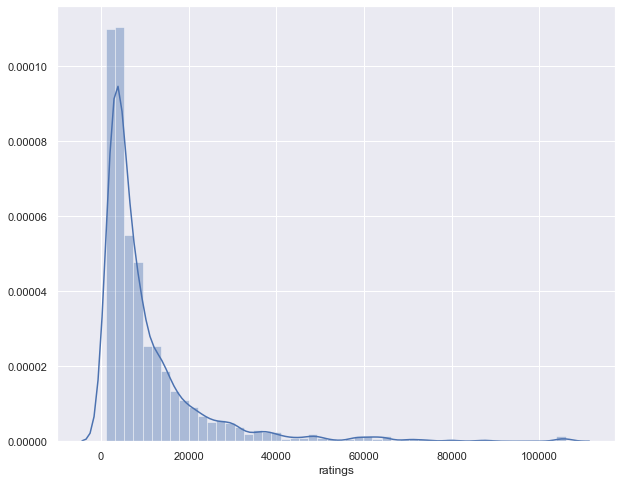

In [216]:
sns.distplot(rating_df['ratings'])

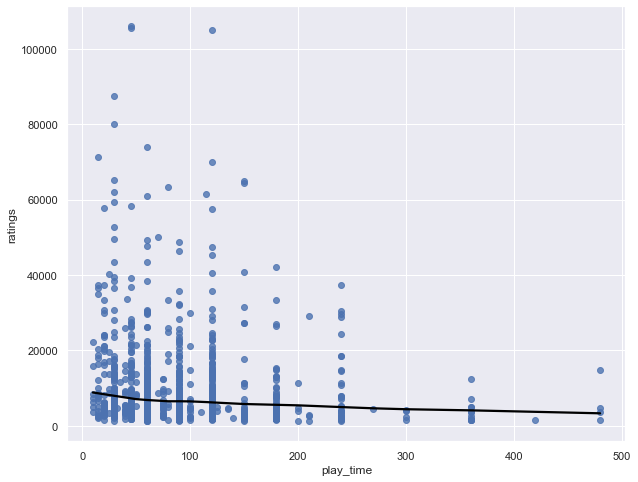

In [217]:
sns.regplot(data=rating_df,
            x='play_time', y='ratings', lowess=True,line_kws={"color": "black"}) #, x_jitter=0.1, y_jitter=5)

Looks to be pretty outliers drive. Let's cut some ratings out and look at a subset of the data

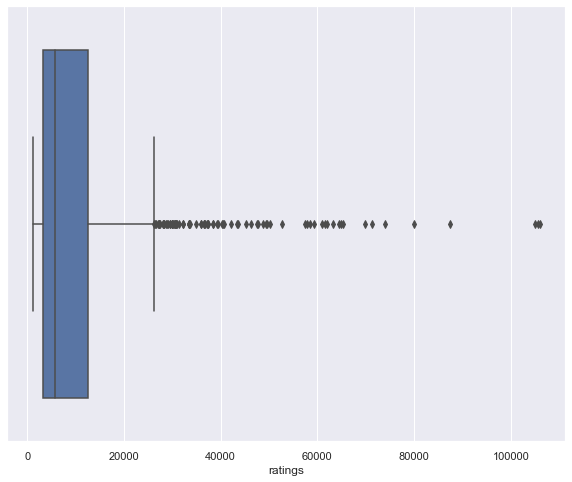

In [218]:
sns.boxplot(rating_df['ratings'])

In [219]:
rating_df[rating_df['ratings'] < 30_000].shape

(936, 5)

We keep 93.6% of the data removing these outliers, so let's remove and look again

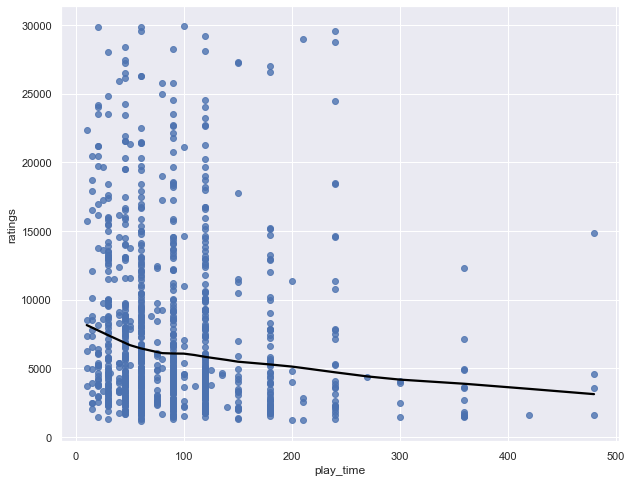

In [220]:
sns.regplot(data=rating_df[rating_df['ratings'] < 30_000],
            x='play_time', y='ratings', lowess=True,line_kws={"color": "black"})

One more time, now let's cut down to under 3 hours

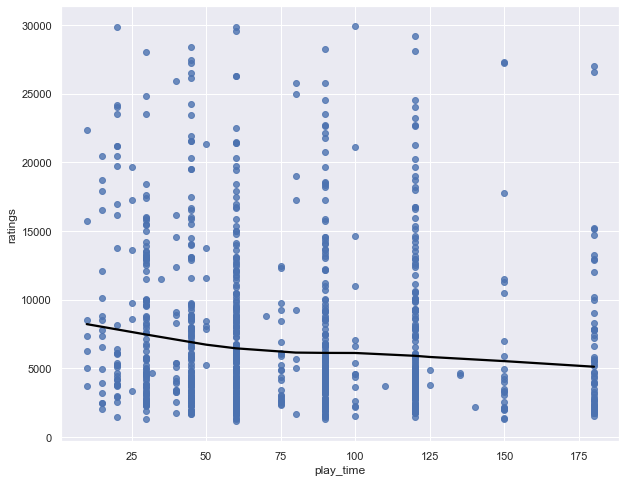

In [221]:
sns.regplot(data=rating_df[(rating_df['ratings'] < 30_000) & (rating_df['play_time'] <= 180)],
            x='play_time', y='ratings', lowess=True,line_kws={"color": "black"})

Relationship looks weak any way I slide it

In [222]:
model = smf.ols(data=rating_df, formula='ratings~play_time').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ratings   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     12.49
Date:                Sat, 04 Sep 2021   Prob (F-statistic):           0.000429
Time:                        08:46:18   Log-Likelihood:                -10815.
No. Observations:                 997   AIC:                         2.163e+04
Df Residuals:                     995   BIC:                         2.164e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.222e+04    659.168     18.545      0.000    1.09e+04    1.35e+04
play_time    -20.6050      5.831     -3.534      0.000     -32.048      -9.162
==============================================================================
Omnibus:                      753.803   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12404.180
Skew:                           3.403   Prob(JB):                         0.00
Kurtosis:                      18.883   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Every additional minute is assosciated with about 20 fewer ratings. Let's get that as a percentage

In [223]:
model = smf.ols(data=rating_df, formula='ratings~np.log(play_time)').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ratings   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     16.61
Date:                Sat, 04 Sep 2021   Prob (F-statistic):           4.96e-05
Time:                        08:46:19   Log-Likelihood:                -10813.
No. Observations:                 997   AIC:                         2.163e+04
Df Residuals:                     995   BIC:                         2.164e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.013e+04   2431.042      8.282      0.000    1.54e+04    2.49e+04
np.log(play_time) -2290.3440    561.978     -4.076      0.000   -3393.142   -1187.546
==============================================================================
Omnibus:                      754.388   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12501.429
Skew:                           3.404   Prob(JB):                         0.00
Kurtosis:                      18.956   Cond. No.                         28.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A 1% increase in play time is associated with a 22.9 (2290/100) fewer ratings

There is some effect, but it doesn't appear to be practically large.

A few more models, let's see how play time relates to score, holding number of ratings constant. Again, I'll start by moving play time to hours

In [224]:
rating_df['play_time'] = rating_df['play_time'] / 60

In [225]:
model = smf.ols(data=rating_df, formula='score~play_time').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     184.8
Date:                Sat, 04 Sep 2021   Prob (F-statistic):           1.00e-38
Time:                        08:46:19   Log-Likelihood:                -394.43
No. Observations:                 997   AIC:                             792.9
Df Residuals:                     995   BIC:                             802.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2879      0.019    382.785      0.000       7.251       7.325
play_time      0.1374      0.010     13.593      0.000       0.118       0.157
==============================================================================
Omnibus:                       59.312   Durbin-Watson:                   1.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.125
Skew:                           0.588   Prob(JB):                     5.92e-16
Kurtosis:                       3.550   Cond. No.                         3.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [226]:
model = smf.ols(data=rating_df, formula='score~ratings + play_time').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     96.59
Date:                Sat, 04 Sep 2021   Prob (F-statistic):           4.62e-39
Time:                        08:46:19   Log-Likelihood:                -390.80
No. Observations:                 997   AIC:                             787.6
Df Residuals:                     994   BIC:                             802.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2578      0.022    329.654      0.000       7.215       7.301
ratings     2.459e-06   9.13e-07      2.694      0.007    6.68e-07    4.25e-06
play_time      0.1404      0.010     13.851      0.000       0.121       0.160
==============================================================================
Omnibus:                       58.304   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.402
Skew:                           0.575   Prob(JB):                     8.50e-16
Kurtosis:                       3.589   Cond. No.                     3.34e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The coefficient on play time is pretty similar (0.13-0.14) with or without the ratings control variable

One last model, an interaction model. Does the effect of play time change depending on the number of ratings?

For readaibility, let's change ratings into thousnands of ratings

In [227]:
rating_df['ratings'] = rating_df['ratings'] / 1000

In [228]:
model = smf.ols(data=rating_df, formula='score~ratings*play_time').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     69.21
Date:                Sat, 04 Sep 2021   Prob (F-statistic):           1.21e-40
Time:                        08:52:36   Log-Likelihood:                -384.69
No. Observations:                 997   AIC:                             777.4
Df Residuals:                     993   BIC:                             797.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.2956      0.024    298.827      0.000       7.248       7.344
ratings              -0.0019      0.002     -1.248      0.212      -0.005       0.001
play_time             0.1128      0.013      8.816      0.000       0.088       0.138
ratings:play_time     0.0035      0.001      3.499      0.000       0.002       0.005
==============================================================================
Omnibus:                       55.582   Durbin-Watson:                   1.365
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.865
Skew:                           0.548   Prob(JB):                     3.02e-15
Kurtosis:                       3.639   Cond. No.                         67.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
play_time, interaction = model.params['play_time'], model.params['ratings:play_time']

In [237]:
print("At 5k ratings, the effect size is:")
print(round(play_time + interaction*5,2))

print("At 20k ratings, the effect size is:")
print(round(play_time + interaction*20,2))

At 5k ratings, the effect size is:
0.13
At 20k ratings, the effect size is:
0.18


Play time has a large effect on score for a game with more ratings. This is the opposite of what I expected. My expectations was this: as a game gets more ratings, more of the ratings come from people who aren't hardcore fans, lowering the score. However, that is not the case. 

My best just-so story for this result goes like this: games with more ratings are more accessable. As such, if a 2 hour game has 20,000 ratings, it's two hours probably feel like less of a slog than one with 5,000 ratings, thus making it a better game.